<a href="https://www.kaggle.com/carrollstreet/churn-analysis?scriptVersionId=88712831" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Способы исследования текучести персонала
---

## Содержание:
1.  [Вступление](#start)
2. [Проблема](#problem)
3. [Изучение и предобработка данных](#preprocessing)
4. [Исследовательский анализ](#eda)
5. [Когортный анализ](#cohort)
6. [Исследование Retention Rate](#retention)
7. [Общий вывод](#output)

<a id='start'></a>
## 1. Вступление
---
Всем привет и добро пожаловать на Kaggle! 
<br>Это продвинутый гайд, ориентированный на HR-специалистов и связанный напрямую с анализом данных. У него высокий порог входа, он будет содержать максимальное количество пояснений для сложных тем и минимальное для простых. 
<br>Платформа Kaggle и способ подачи материала были выбраны неспроста. Весь анализ построен на `Python` с использованием библиотек `Pandas`, `Numpy`,`Plotly` и т. д., но не беспокойтесь, вам не придется читать код, хотя у самых любопытных будет такая возможность. Я намеренно отошел от привычного вам `Excel`, поскольку в нём едва ли возможно рассказать историю при помощи данных и тем не менее, большую часть шагов моего исследования вы сможете воспроизвести в этом инструменте и я постараюсь оставить для этого максимум ссылок. Kaggle был выбран потому, что предоставляет максимальную гибкость для презентации исследований. 
<br>Данные для анализа были сгенерированы случайным образом, некоторые взаимосвязи намеренно гиперболизированы для большей наглядности. Код генерации содержится во второй ячейке.
<br>По ходу анализа я буду давать рекомендации по возможным шагам в плане проведения дополнительных активностей и это не обязательно будет означать, что их необходимо было бы применить в контексте текущей истории.
<br>Сгенерированные данные можно скачать по [ссылке](https://www.kaggle.com/carrollstreet/hiring-data).
<a id='problem'></a>
## 2. Проблема
---
Предположим, что сейчас январь 2021 года, вы HR-специалист некоторой IT-компании, которая испытывает кадровый кризис. 
Чтобы примерно оценить масштабы вашего бизнеса, предположим, что последние пару лет он переживал бурный рост и найм составлял до 300 сотрудников в год, но в данный момент он несколько сократился и вы захотели поглубже разобраться в причинах. Вы решили, что лучше всего будет начать расследование с изучения данных за предыдущий период и в зависимости от полученных результатов определить дальнейшие шаги. Вы обратились в отдел кадров или сделали выгрузку из вашей `ATS`/`CRM`, с целью собрать данные по сотрудникам, нанятым за 2020-й год и все, что вам удалось получить, это таблицу с тремя столбцами:

1. `employee_id` - уникальный идентификатор сотрудника 
2. `start_date` - дата найма сотрудника (фактически дата начала работы в компании)
3. `end_date` - дата увольнения сотрудника


Так как исследование строится на синтетических данных и не ставит перед собой цели углубленного анализа причин оттока, введем следующие ограничения:
- вам достоверно известно, что соотношение мотивации увольнений (по собственной инициативе или по инициативе нанимателя) в вашей компании имеет постоянную величину и одинаково для всех исследуемых групп. Допустим, 10% по инициативе нанимателя и 90% по инициативе сотрудника
- вам достоверно известно, что соотношение уровней специалистов, уходящих в отток, соответствует историческим данным в вашей компании и одинаково для всех исследуемых групп. Допустим, 30% специалисты уровня Senior и выше, 50% специалисты уровня Middle, 20% специалисты уровня Junior


*Еще раз отмечу, что вы изучаете данные только тех сотрудников, которые пришли в 2020-м году, это значит, что те сотрудники, которые пришли ранее, но уволились в 2020-м, в этой таблице находиться не будут.*

<a id='preprocessing'></a>
## 3. Изучение и предобработка данных
---

In [1]:
from datetime import datetime
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

In [2]:
np.random.seed(42)

calendar = pd.date_range(start='01/01/2020', end='31/12/2020', freq='B') 

true_weigths=(pd.Series(calendar.month % 12).value_counts().sort_index()).to_frame('count')
true_weigths.index.values[0] = 12
true_weigths['monthly_weight'] = true_weigths['count'] / len(calendar)
weights_correction = np.array([-0.04, -0.02,0.045,0.025,0.04,0.03,0.02,0.02,-0.03,-0.04,-0.02,-0.03])
true_weigths['monthly_weight'] = true_weigths['monthly_weight'] + weights_correction
true_weigths['daily_weight'] = true_weigths['monthly_weight'] / true_weigths['count']
true_weigths = true_weigths.sort_index()

weights = []
for k,i in zip(true_weigths['count'], true_weigths['daily_weight']):
    weights.extend(k*[i])
    
start_date = np.random.choice(calendar, replace=True, size=226, p=weights)

hires = pd.Series(start_date).sort_values().to_frame('start_date').reset_index(drop=True)
hires.index.name = 'employee_id'
hires= hires.reset_index()

trial = np.abs(np.random.normal(50,20,30).astype(int))
full = np.abs(np.random.normal(180,50,80).astype(int))

np.random.seed(12)
deltas = np.random.choice([*trial,*full,*([None]*140)], size=226, replace=True)
hires['end_date'] = hires['start_date'] + pd.to_timedelta(deltas,'d')
hires.loc[hires['end_date'].dt.year != 2020, 'end_date'] = None
hires.loc[hires['start_date'] == '2020-01-28', 'end_date'] = datetime(2020,12,3)
hires.loc[hires['start_date'] == '2020-01-22', 'end_date'] = datetime(2020,11,14)
hires.loc[hires['start_date'] == '2020-02-21', 'end_date'] = datetime(2020,12,18)

Итак, давайте посмотрим, как выглядят наши данные. Выведу первые 10 записей, а затем посчитаю, сколько в каждом столбце имеется непустых значений:

In [3]:
hires.head(10)

,employee_id,start_date,end_date
0,0,2020-01-02,2020-05-28
1,1,2020-01-02,NaT
2,2,2020-01-03,NaT
3,3,2020-01-06,NaT
4,4,2020-01-08,NaT
5,5,2020-01-09,2020-03-15
6,6,2020-01-13,NaT
7,7,2020-01-15,2020-10-09
8,8,2020-01-16,NaT
9,9,2020-01-17,2020-03-10


*`NaN` или `NaT` - в нашем контексте "пустые" значения. Если напротив конкретной записи `start_date` в столбце `end_date` встречается `NaT`, значит сотрудник работает в компании на текущий момент. Какой-то другой смысловой нагрузки для читателя эта запись не несет, поэтому далее не будем возвращаться к этому вопросу.

In [4]:
hires.count().to_frame('count')

,count
employee_id,226
start_date,226
end_date,64


За 2020 год было 226 наймов, 64 сотрудника уволилось. Прежде чем считать долю уволенных, давайте порассуждаем, а что мы в принципе можем узнать из этих данных кроме соотношения? У нас есть всего 3 столбца и на первый взгляд может показаться, что это очень скудная информация и едва ли на её основе можно извлечь серьезные выводы. На самом деле это не совсем так и далее мы в этом убедимся, но сперва подумайте, какую информацию можно получить на основе даты старта работы и даты увольнения? 

<br>Мы можем:
- из стартовой даты [выделить кварталы](https://excel2.ru/articles/nomer-kvartala-v-ms-excel)
- из стартовой даты [выделить месяцы](https://support.microsoft.com/ru-ru/office/%D0%BC%D0%B5%D1%81%D1%8F%D1%86-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F-%D0%BC%D0%B5%D1%81%D1%8F%D1%86-579a2881-199b-48b2-ab90-ddba0eba86e8)
- из даты увольнения выделить месяцы
- на основе [разности](https://support.microsoft.com/ru-ru/office/%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B8-%D0%B4%D0%B2%D1%83%D1%85-%D0%B4%D0%B0%D1%82-8235e7c9-b430-44ca-9425-46100a162f38) между датой увольнения и датой начала работы получить число дней, которые проработал сотрудник

Произведем все вычисления и выведем первые 10 строк получившейся таблицы:

In [5]:
hires['start_month'] = hires['start_date'].dt.to_period('M').dt.to_timestamp()
hires['end_month'] = hires['end_date'].dt.to_period('M').dt.to_timestamp()
hires['quarter'] = hires['start_date'].dt.quarter
hires['period_days'] =(hires['end_date'] - hires['start_date']) / np.timedelta64(1,'D')

In [6]:
hires.head(10)

,employee_id,start_date,end_date,start_month,end_month,quarter,period_days
0,0,2020-01-02,2020-05-28,2020-01-01,2020-05-01,1,147.0
1,1,2020-01-02,NaT,2020-01-01,NaT,1,NaN
2,2,2020-01-03,NaT,2020-01-01,NaT,1,NaN
3,3,2020-01-06,NaT,2020-01-01,NaT,1,NaN
4,4,2020-01-08,NaT,2020-01-01,NaT,1,NaN
5,5,2020-01-09,2020-03-15,2020-01-01,2020-03-01,1,66.0
6,6,2020-01-13,NaT,2020-01-01,NaT,1,NaN
7,7,2020-01-15,2020-10-09,2020-01-01,2020-10-01,1,268.0
8,8,2020-01-16,NaT,2020-01-01,NaT,1,NaN
9,9,2020-01-17,2020-03-10,2020-01-01,2020-03-01,1,53.0


Опишу новые столбцы:
- `start_month` - месяц, в котором сотрудник вышел на работу
- `end_month` - месяц, в котором сотрудник покинул компанию
- `quarter` - номер квартала, в котором сотрудник вышел на работу
- `period_days` - количество дней, которые сотрудник проработал в компании

Таким образом, получена большая часть необходимых данных и теперь мы можем приступить к исследованию.

<a id='eda'></a>
## 4. Исследовательский анализ
___

Возможно, первое, что вам бы захотелось узнать - рассчитать средний период работы на уволившегося сотрудника. Давайте построим [гистограмму](https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D1%81%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0) (используется для оценки частоты встречаемости значений) и посмотрим, как распределены данные в нашей выборке:

*Узнать, как построить гистограмму в `Excel`, можно [здесь](https://support.microsoft.com/ru-ru/office/%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B3%D0%B8%D1%81%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D1%8B-85680173-064b-4024-b39d-80f17ff2f4e8#OfficeVersion=Windows).

In [7]:
def mean_period(series):
    return int(series.mean())

def hist(series, label, x,y,color=None, bins=10, title=None):
    hist_mean = mean_period(series)
    sns.histplot(series, kde=True, color=color,label=label, bins=bins)
    plt.axvline(hist_mean, color='#a83269', linewidth=3,alpha=0.7, label='mean', )
    plt.annotate(f'mean: {hist_mean} дней', xy=(hist_mean+x,y), bbox={'boxstyle':'round', 'fc':'0.8'})
    plt.title(title)
    plt.xlabel('период работы')
    plt.ylabel('частота значений')
    plt.legend()

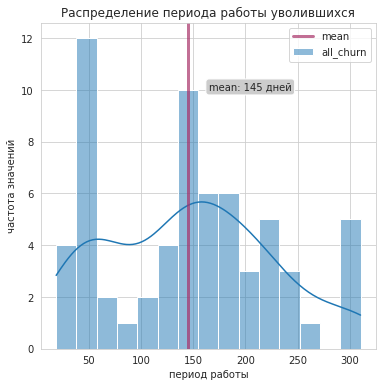

In [8]:
plt.figure(figsize=(6,6))
hist(hires['period_days'], label='all_churn', x=20,y=10, bins=15, title='Распределение периода работы уволившихся')
plt.show()

Красной линией на графике отмечено положение среднего в выборке и оно составляет 145 дней. Первое, что бросается в глаза, это то, что наше распределение бимодально (то есть у него две моды, а на графике выделяются два "горба"), это можно интерпретировать так, что оно состоит из нескольких однородных выборок. Тогда оценка среднего периода работы по такому распределению не всегда будет корректной.
<br>Кто-то мог уже догадаться, что распределение состоит из данных тех сотрудников, которые ушли во время испытательного срока и после него. Давайте выделим еще один столбец, в котором и будет содержаться эта информация.


Если вы не получили эту информацию заранее из `ATS` или у вас нет возможности её выгрузить, можно воспользоваться функцией "[если](https://support.microsoft.com/ru-ru/office/%D0%B5%D1%81%D0%BB%D0%B8-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F-%D0%B5%D1%81%D0%BB%D0%B8-69aed7c9-4e8a-4755-a9bc-aa8bbff73be2)" в `Excel`. Например: если срок работы <= 91 (или 92), тогда сотрудник ушел с испытательного, если больше, соответственно, ушел после испытательного. Не забудьте пройтись по выделенным данным, поскольку суммарно три месяца могут составлять 90 дней (с января по март включительно) и в редких случаях сотрудник может быть неверно отмечен ушедшим с испытательного срока. 

Извлеку данные и выведу первые 10 записей полученной таблицы:

In [9]:
hires.loc[(((hires['end_date']- np.timedelta64(3,'M'))- hires['start_date'])/np.timedelta64(1,'D')) <= 0,'is_probation']= 1
hires.loc[hires['end_date'].notna() & hires['is_probation'].ne(1), 'is_probation'] = 0 

In [10]:
hires.head(10)

,employee_id,start_date,end_date,start_month,end_month,quarter,period_days,is_probation
0,0,2020-01-02,2020-05-28,2020-01-01,2020-05-01,1,147.0,0.0
1,1,2020-01-02,NaT,2020-01-01,NaT,1,NaN,NaN
2,2,2020-01-03,NaT,2020-01-01,NaT,1,NaN,NaN
3,3,2020-01-06,NaT,2020-01-01,NaT,1,NaN,NaN
4,4,2020-01-08,NaT,2020-01-01,NaT,1,NaN,NaN
5,5,2020-01-09,2020-03-15,2020-01-01,2020-03-01,1,66.0,1.0
6,6,2020-01-13,NaT,2020-01-01,NaT,1,NaN,NaN
7,7,2020-01-15,2020-10-09,2020-01-01,2020-10-01,1,268.0,0.0
8,8,2020-01-16,NaT,2020-01-01,NaT,1,NaN,NaN
9,9,2020-01-17,2020-03-10,2020-01-01,2020-03-01,1,53.0,1.0


В таблицу добавлен столбец `is_probation`. Поясню, что означают записи в нём:
- `is_probation` = 0, если сотрудник ушел из компании после испытательного срока
- `is_probation` = 1, если сотрудник ушел во время испытательного срока

С помощью [круговой диаграммы](https://support.microsoft.com/ru-ru/office/%D0%B4%D0%BE%D0%B1%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BA%D1%80%D1%83%D0%B3%D0%BE%D0%B2%D0%BE%D0%B9-%D0%B4%D0%B8%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D1%8B-1a5f08ae-ba40-46f2-9ed0-ff84873b7863) теперь можем оценить соотношение уволившихся сотрудников к текущим:

In [11]:
fig = go.Figure(go.Pie(labels=['current_employee', 'churn_after_probation', 'churn_on_probation'], textposition='auto',
                      values=hires['is_probation'].value_counts(dropna=False), textinfo='value+percent',pull=0.05))
fig.update_layout(title={'text':'Диаграмма соотношения уволившихся сотрудников к текущим', 'x':.45})
fig.show()

- `churn_on_probation` - сотрудники уволившиеся на испытательном
- `churn_after_probation` - сотрудники уволившиеся после испытательного

Таким образом, 28.3% всех нанятых сотрудников за год ушли в отток, 8.4% составили сотрудники, которые ушли с испытательного срока. Среди всех уволившихся, сотрудники не прошедшие испытательный срок составляют 29.7%.

Проблема может быть со стороны:
- не отлаженного процесса рекрутинга (а именно оценки)
- условий работы 
- модели взаимодействия менеджмента с персоналом 
- системы удержания и мотивации
- внешних факторов и др.

*Для более углубленного анализа можно изучить данные за несколько лет: сравнить их с полученными за текущий год, собрать причины увольнений и попробовать систематизировать их. В том числе подумать, могли ли повлиять на отток за конкретный период внешние факторы.*


Пока продолжим собирать инсайты и построим гистограммы периода работы уже для двух выборок и рассчитаем средние для них (в `Excel` поможет [фильтрация](https://support.microsoft.com/ru-ru/office/%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B2-%D0%B4%D0%B8%D0%B0%D0%BF%D0%B0%D0%B7%D0%BE%D0%BD%D0%B5-%D0%B8%D0%BB%D0%B8-%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B5-01832226-31b5-4568-8806-38c37dcc180e)):

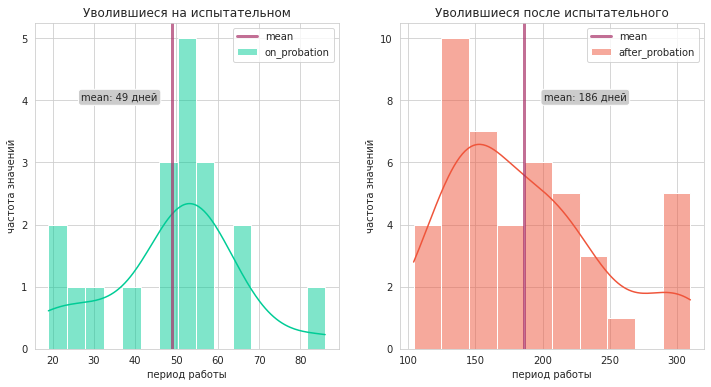

In [12]:
plt.subplots(figsize=(12,6))

plt.subplot(1,2,1)
hist(hires.query('is_probation==1')['period_days'], label='on_probation', color='#00CC96', x=-22,y=4, bins=15, title='Уволившиеся на испытательном')

plt.subplot(1,2,2)
hist(hires.query('is_probation==0')['period_days'], label='after_probation', color='#EF553B', x=15,y=8, title='Уволившиеся после испытательного')
plt.show()

Таким образом мы узнали, что каждый уволившийся сотрудник с испытательного срока в среднем проработал в компании 49 дней, а уволившийся после испытательного срока проработал в среднем 186 дней. Прежде чем делать выводы на основе этой информации посмотрим на данные немного в другом разрезе - построим [диаграммы размаха](https://ru.wikipedia.org/wiki/%D0%AF%D1%89%D0%B8%D0%BA_%D1%81_%D1%83%D1%81%D0%B0%D0%BC%D0%B8) для двух групп уволившихся:

*Узнать, как построить диаграмму размаха в `Excel`, можно [здесь](https://support.microsoft.com/ru-ru/office/%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B1%D0%BB%D0%BE%D1%87%D0%BD%D0%BE%D0%B9-%D0%B4%D0%B8%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D1%8B-%D1%81-%D0%BE%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D1%8F%D0%BC%D0%B8-%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%BE%D0%B2-62f4219f-db4b-4754-aca8-4743f6190f0d).

In [13]:
box = []
for c,k,i in zip(['#00CC96','#EF553B'],['churn_on_probation','churn_after_probation'], sorted(hires['is_probation'].dropna().unique(),reverse=True)):
    box_data = hires.query('is_probation == @i')['period_days']
    box += [go.Box(y=box_data,name=k,boxpoints='all', marker_color=c, hoverinfo='y')]
    
fig = go.Figure(box)
fig.update_layout(template='plotly_white',showlegend=False, yaxis={'title':'период работы'},
                  title={'text':'Диаграммы размаха по группам среди уволившихся сотрудников', 'x':0.5})
fig.show()

Давайте разбираться. Точки слева от "ящиков" представляют конкретные значения периода работы из выборки. Размер каждой диаграммы говорит о разбросе в данных, чем больше размах (т. е. разность между максимумом и минимумом), тем больше сама диаграмма. Диаграммы размаха дают много информации, например по ним можно изучить описательные статистики, выявить аномально низкие и аномально высокие значения, оценить распределение. 

Какие выводы можно извлечь:
- по значениям третьего [квартиля](https://ru.wikipedia.org/wiki/%D0%9A%D0%B2%D0%B0%D0%BD%D1%82%D0%B8%D0%BB%D1%8C#%D0%9C%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D0%B0_%D0%B8_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D0%B8) можно сказать, что 75% всех увольнений с испытательного происходят через 56 дней после найма в компанию и 75% всех увольнений сотрудников, которые прошли испытательный, происходят через 217 дней после найма
- оба распределения имеют ассиметрию относительно центра. Для `churn_on_probation` высокие значения более скучены по сравнению с низкими.  Например, 3-й квартиль отличается от медианы всего на 3.5 дня (то есть 25% увольнений происходит в этом трехдневном интервале), тогда как 1-й квартиль отличается на 10 дней. На этот индикатор стоит обратить внимание в контексте исторических данных с целью поиска тенденции к оттоку в этом периоде. 

*Если схожие закономерности сохраняются и за предыдущие годы, вы можете скорректировать статистики большим объёмом данных, проанализировать причины оттока и попробовать разработать механизмы по удержанию сотрудников*

*Снова обращу внимание на то, что мы рассматриваем данные в динамике за один год и именно она нас и интересует. Средний период работы в компании на человека за все время её существования скорее всего будет сильно отличаться 


Изучим, как распределился найм по кварталам при помощи [столбчатой диаграммы](https://support.microsoft.com/ru-ru/office/%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B4%D0%B8%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D1%8B-%D0%BE%D1%82-%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D0%B0-%D0%B4%D0%BE-%D0%BA%D0%BE%D0%BD%D1%86%D0%B0-0baf399e-dd61-4e18-8a73-b3fd5d5680c2):

In [14]:
quarter = hires['quarter'].value_counts().to_frame('count').join(hires['quarter'].value_counts(normalize=True).apply(lambda x: '{:.0%}'.format(x)).to_frame('ratio'))
fig = go.Figure(go.Bar(x=quarter.index, y=quarter['count'], textposition='auto', text=quarter['ratio'], hoverinfo='x+y'))
fig.update_layout(template='plotly_white',xaxis={'type':'category','title':'номер квартала'}, hovermode='x',
                  yaxis={'title':'число сотрудников'}, title={'text':'Распределение найма по кварталам', 'x':0.5})
fig.show()

Если в первом и втором квартале найм приблизительно эквивалентный, то есть 77 и 70 сотрудников, то далее заметно резкое снижение. 4-й квартал принес всего 15% сотрудников от общего найма. Попробуем разобраться в чем дело. В этот раз построим столбчатую диаграмму по месяцам и на ней будем отображать не только количество нанятых сотрудников на каждый месяц, а также и тех, кто ушел из компании в конкретный период:

In [15]:
month_hire = hires['start_month'].value_counts()
month_churn = (0 - hires.groupby(['end_month','is_probation'])['period_days'].count()).reset_index('is_probation')

charts = []
for k,i in zip(['churn_after_probation', 'churn_on_probation'],hires['is_probation'].dropna().unique()):
    data = month_churn.query('is_probation == @i')
    charts += [go.Bar(x=data.index, y=data['period_days'], name=k,
                      textposition='auto', text=data['period_days'].abs(), hoverinfo="text")]
    
fig=go.Figure([go.Bar(x=month_hire.index,y=month_hire,name='total_hires',textposition='auto',text=month_hire, 
                      hoverinfo="text"),*charts])
fig.update_layout(barmode='relative',template='plotly_white', hovermode='x', uniformtext_mode='hide', uniformtext_minsize=12, yaxis={'title':'число сотрудников'}, height=650,
                 width=850, title={'text':'Распределение найма и текучести по месяцам', 'x':0.45}, legend={'x':.75, 'y':1})

fig.show()

График иллюстрирует то, что отток начался с августа 2020 года, также с августа резко снизились показатели найма. Возможно изменились условия рынка и компания оказалась к этому не готова, например значительно большая часть кандидатов захотела иметь возможность полноценной удаленной работы, либо возможность релоцироваться. Конкретно на отток могло повлиять то, что компания не смогла предпринять дополнительные шаги по удержанию персонала. Для полноценного понимания проблемы необходимо систематизировать причины отказа кандидатов и причины увольнения сотрудников.


Продолжим исследование - попробуем разделить сотрудников на когорты и посмотрим, как они ведут себя с течением времени.

<a id='cohort'></a>
## 4. Когортный анализ
___

Когортный анализ, это метод исследования, который часто применяется в маркетинговой и продуктовой аналитике. Его суть заключается в том, что группу людей рассматривают не как единое множество, а разделяют на подгруппы - когорты. Когорта, в свою очередь, это группа людей, которая совершила целевое действие за конкретный временной промежуток. В нашем случае пример одной когорты - сотрудники, которые пришли в компанию в январе 2020 года, соответственно, в следующей когорте будут находиться сотрудники, которые пришли в феврале 2020 года и т. д. Когортный анализ помогает выявить тренды в поведении людей с течением времени и при помощи него мы можем ответить на вопрос, сколько сотрудников из разных когорт осталось в компании на конкретный месяц, рассчитать коэффициент удержания и оттока, исследовать любое целевое действие.

В русскоязычном сегменте интернета я не нашел статьи про построение когортного анализа для исследования текучести персонала, поэтому оставлю ссылки на статьи по продуктовому анализу от [OWOX](https://www.owox.ru/), концепция анализа одинакова для всех областей, различаются только группы, наборы данных и исследуемые действия.
- [Что такое когортный анализ](https://www.owox.ru/blog/use-cases/cohort-analysis/)
- [Retention Rate или коэффициент удержания](https://www.owox.ru/blog/articles/customer-retention/)
- [Churn Rate или коэффициент оттока](https://www.owox.ru/blog/articles/churn-rate/)


Итак, приступим к анализу. 
<br>Для того, чтобы выделить когорты, нам понадобится исходная таблица, выведу её первые 5 записей:

In [16]:
cohort_data = hires[['employee_id','start_date','end_date']].copy()
cohort_data.head()

,employee_id,start_date,end_date
0,0,2020-01-02,2020-05-28
1,1,2020-01-02,NaT
2,2,2020-01-03,NaT
3,3,2020-01-06,NaT
4,4,2020-01-08,NaT


Следующим этапом необходимо [объединить](https://www.ablebits.com/office-addins-blog/2018/10/31/excel-merge-tables-matching-columns/) столбцы `start_date` и `end_date` по столбцу `employee_id`, чтобы на всех уволившихся сотрудников в одном столбце содержалось по две записи, таким образом мы сформируем столбец жизненного цикла когорты. Затем вам понадобится снова взять столбец `start_date` из исходной таблицы и объединить его с новой таблицей (просто скопировать и вставить не получится, так как таблицы после первой склейки будут разного размера). Для большей наглядности выведу следующие 10 строк получившейся таблицы, где будут содержаться по две записи на одного и того же сотрудника:

In [17]:
cohort_data = (pd.melt(cohort_data, id_vars=['employee_id'], value_vars=['start_date','end_date'], value_name='dates_lifetime')
               .dropna().drop('variable', axis=1).reset_index(drop=True))
cohort_data['start_date'] = cohort_data.groupby('employee_id')['dates_lifetime'].transform(min)
cohort_data[cohort_data['employee_id'].duplicated(keep=False)].sort_values(by=['employee_id','dates_lifetime']).head(10)

,employee_id,dates_lifetime,start_date
0,0,2020-01-02,2020-01-02
226,0,2020-05-28,2020-01-02
5,5,2020-01-09,2020-01-09
227,5,2020-03-15,2020-01-09
7,7,2020-01-15,2020-01-15
228,7,2020-10-09,2020-01-15
9,9,2020-01-17,2020-01-17
229,9,2020-03-10,2020-01-17
10,10,2020-01-20,2020-01-20
230,10,2020-04-15,2020-01-20


Теперь, все что необходимо, это снова выделить месяц из столбцов `start_date` и `dates_lifetime` и построить [сводную таблицу](https://support.microsoft.com/ru-ru/office/%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-%D1%81%D0%B2%D0%BE%D0%B4%D0%BD%D0%BE%D0%B9-%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D1%8B-%D0%B4%D0%BB%D1%8F-%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%BB%D0%B8%D1%81%D1%82%D0%B0-a9a84538-bfe9-40a9-a8e9-f99134456576), где по строкам будет месяц начала работы сотрудника, а по столбцам будет месяц жизненного цикла, в качестве значений для группировки можно использовать количество `employee_id`. Таким образом у вас получится когортная матрица, где на главной диагонали будет число сотрудников, которые приходили каждый месяц, а по датам жизненного цикла число уволенных сотрудников. После этого необходимо по каждой строке когорты вычесть из общего числа сотрудников число уволенных. Например в январскую когорту пришло 17 человек, из неё в феврале уволилось 0 (значит остается 17-0=17), затем в марте уволилось 2, тогда 17-2=15 и так далее, в результате чего у вас получится когортная матрица оттока, на основе которой можно построить [тепловую карту](https://exceltable.com/shablony-skachat/teplovaya-karta-v-excel):

*В интернете описано множество способов построения когортной матрицы и вполне возможно, что вы найдете для себя более подходящий и простой вариант* 

In [18]:
cohort_data['dt_month'] = cohort_data['dates_lifetime'].astype('datetime64[M]')
cohort_data['start_month'] = cohort_data['start_date'].astype('datetime64[M]')

cohort_pivot = cohort_data.pivot_table(index='start_month', columns='dt_month', values='employee_id', aggfunc='count',fill_value=0)

def cumdiff(x): return reduce(lambda a,b : abs(a-b),x)
cohort_pivot = cohort_pivot.expanding(axis=1).apply(cumdiff)
cohort_pivot = (cohort_pivot.stack().to_frame('count').reset_index()
                            .query('start_month <= dt_month')
                            .set_index(['start_month','dt_month'])['count'].unstack())

cohort_pivot.index = cohort_pivot.index.strftime('%Y-%m')
cohort_pivot.columns = cohort_pivot.columns.strftime('%Y-%m')

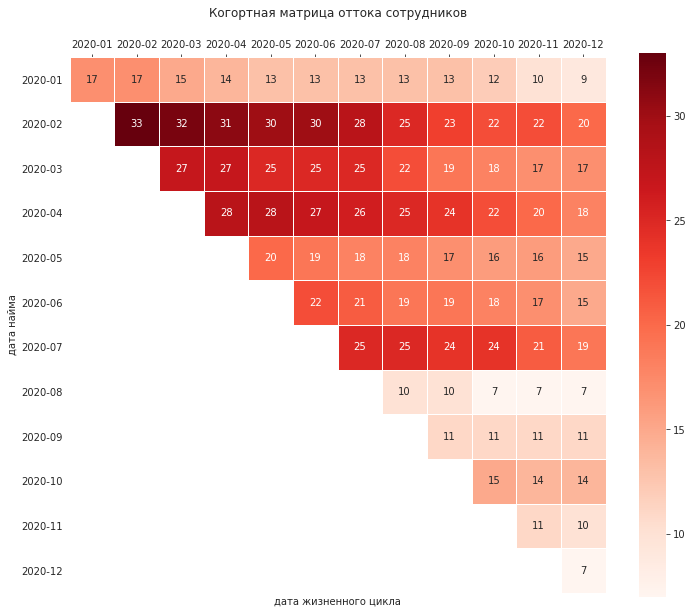

In [19]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(cohort_pivot, annot=True, linewidths=1,square=True, cmap='Reds') 
ax.xaxis.tick_top()
plt.xlabel('дата жизненного цикла')
plt.ylabel('дата найма')
plt.title('Когортная матрица оттока сотрудников',pad=40)
plt.yticks(rotation = 0)
plt.show()

Таким образом у нас получилось визуализировать ежемесячный отток сотрудников для каждой когорты. Можно заметить, что сентябрьская когорта оказалось самой стойкой, на 4-й месяц она не потеряла ни одного сотрудника. Теперь мы можем просуммировать все строки между собой и тогда мы получим реальное число сотрудников в компании с учетом оттока на каждый месяц. 

Используя эти данные построим столбчатую диаграмму:

In [20]:
hires_churn = cohort_pivot.sum(axis=0)

fig = go.Figure(go.Bar(x=hires_churn.index, y=hires_churn, hoverinfo='x+text', textposition='outside', text=hires_churn,
                      marker=dict(cmin=0, color=hires_churn, colorbar=dict(title=''),colorscale="Reds")))
fig.update_layout(template='plotly_white', xaxis={'title':'дата жизненного цикла'}, hovermode='x', yaxis={'title':'число сотрудников'},
                 title={'text':'Рост числа сотрудников с учетом оттока', 'x':0.5})
fig.show()

График показывает, что с июля рост числа сотрудников в компании замедлился и практически остановился, то есть рекрутинг стал работать в ноль, а в декабре суммарный штат даже сократился по сравнению с двумя предыдущими месяцами. 

<a id='retention'></a>
## 6. Исследование Retention Rate 
___

Мы приближаемся к самой интригующей части нашего анализа - исследованию коэффициента удержания. Сложно переоценить его важность для бизнеса, он может показывать и лояльность сотрудников к компании, качество механизмов удержания, разработанных HR, тенденции к оттоку и т. д. Поскольку данные приводятся к единому масштабу (от 0 до 1 или от 0% до 100%), когорты становится намного проще исследовать и выявлять тренды в их поведении.  

Для исследования `Retention Rate` нам потребуется ввести новую переменную - "время жизни" (`lifetime`), в таблице она будет выглядеть не как дата жизненного цикла, она будет показывать в каком по счёту месяце от месяца когорты произошло целевое действие. Таким образом стартовый месяц работы в компании для всех когорт будет их первым месяцем жизненного цикла, а первые 4 месяца жизненного цикла очень наглядно покажут, как сотрудники каждой когорты справляются с испытательным сроком.

Для того, чтобы выделить `lifetime`, надо из месяца жизненного цикла вычесть месяц старта работы, если значения получаются дробными, их надо округлить и привести к целочисленному типу. Для того, чтобы построить когортную матрицу необходимо создать сводную таблицу, где по строкам будет месяц начала работы сотрудника, а по столбцам будет `lifetime`, в качестве значений для группировки можно использовать количество `employee_id`. В полученной матрице вам снова необходимо вычесть из общего числа сотрудников число уволенных по каждой строке когорты, при этом учитывайте, что после операции вычитания матрица должна сохранить первоначальную форму, то есть записей ниже побочной диагонали быть не должно. Заключительным этапом необходимо разделить все столбцы матрицы на первый столбец жизненного цикла, таким образом мы получим относительное число сотрудников на каждый месяц жизненного цикла. Теперь можно строить тепловую карту:

In [21]:
cohort_data['cohort_lifetime'] = ((cohort_data['dt_month'] - cohort_data['start_month']) / np.timedelta64(1,'M')).round().astype(int) + 1

stack = cohort_data.pivot_table(index='start_month', 
                                columns='cohort_lifetime',
                                values='employee_id', 
                                aggfunc='count',
                                fill_value=0).stack().to_frame('count').reset_index()

stack['lifetime_range'] = ((stack['start_month'].max() - stack['start_month']) / np.timedelta64(1,'M')).round() + 1 
stack['first_month_count'] = stack.groupby('start_month')['count'].transform('max')
stack = stack.query('cohort_lifetime <= lifetime_range').set_index(['start_month','cohort_lifetime'])
pivot = stack['count'].unstack().expanding(axis=1).apply(cumdiff)

retention = pivot.div(pivot[1], axis=0)
retention.index = retention.index.strftime('%Y-%m')

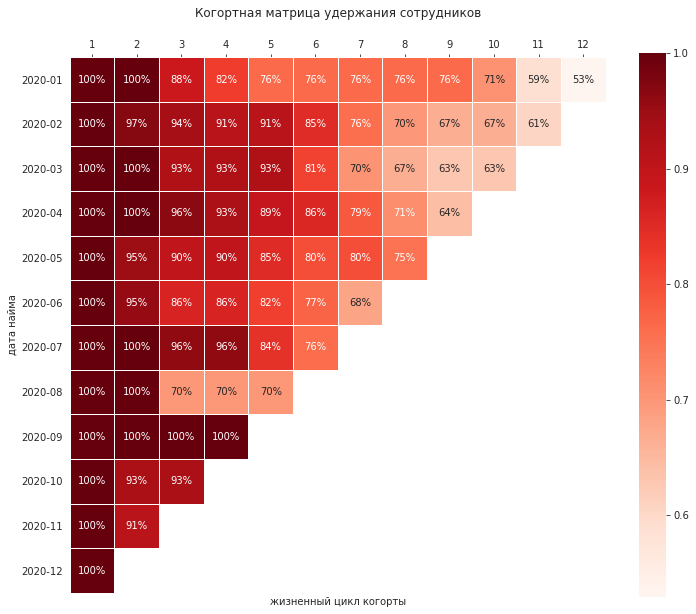

In [22]:
plt.figure(figsize=(12,10))
ax = sns.heatmap(retention, annot=True, linewidths=1,square=True, cmap='Reds', fmt='.0%') 
ax.xaxis.tick_top()
plt.xlabel('жизненный цикл когорты')
plt.ylabel('дата найма')
plt.title('Когортная матрица удержания сотрудников',pad=40)
plt.yticks(rotation = 0)
plt.show()

Как читать эту таблицу? Главное, что нужно понимать, это то, что на каждый месяц жизненного цикла когорты мы получаем фактическое число сотрудников в этот месяц. В первом месяце доля на каждую группу составляет 100% от изначальной, то есть в январе пришло 17 человек, в феврале 33 и т. д., затем мы подсчитали, сколько человек осталось на втором месяце жизненного цикла (по сути ушло за первый месяц), для первой когорты ничего не изменилось, для февральской в её первом месяце ушел один человек, таким образом 32/33 = 0.97. 
<br>Почему количество месяцев жизненного цикла сокращается на каждую когорту? Например, люди, которые пришли в компанию в ноябре 2020 года успели проработать в ней всего 2 месяца (поскольку мы взяли данные только за 2020-й год). 

По этой матрице можно сказать, что:
- относительная численность первой когорты сотрудников сократилась на 47% на 12-й месяц жизненного цикла 
- в первый месяц испытательного срока оттока сотрудников почти не происходит, основной отток начинается на второй месяц
- на 9-й месяц жизненного цикла численность сотрудников в трех когортах (февраль/март/апрель) упала ниже 70%. Если бы мы располагали данными за более длительный период, упала бы численность остальных когорт ниже 70% на 9-й месяц?
- как уже было отмечено выше сентябрьская когорта оказалась самой стойкой и сохранила 100% сотрудников на 4й месяц жизненного цикла


Теперь мы можем рассчитать общий коэффициент удержания по всем когортам на каждый месяц жизненного цикла. Для этого мы суммируем всех оставшихся сотрудников на каждый месяц жизненного цикла и делим их на изначальное суммарное число сотрудников из оставшихся когорт. Например на 11-й месяц жизненного цикла в январской когорте осталось 10 человек, в февральской 20, изначально в эти месяцы были наняты 17 и 33 человека. Тогда общий коэффициент удержания на этот месяц составит (10+20) / (17+33) * 100% = 60% (считаем только для двух когорт, так как остальные еще не прожили 11 месяцев).

In [23]:
lifetime_retention = pivot.sum() / stack['first_month_count'].unstack().sum() * 100
fig = go.Figure(go.Bar(x=lifetime_retention.index,y=lifetime_retention.round(2),textposition='outside',
                       text=lifetime_retention.apply(lambda x: '{:.0f}%'.format(x)),hoverinfo='text+x',
                       marker=dict(cmin=0, color=lifetime_retention, colorbar=dict(title=''),colorscale="Reds")))
fig.update_layout(template='plotly_white', hovermode='x', xaxis={'type':'category', 'title':'жизненный цикл когорты'},
         yaxis={'title':'retention (%)', 'range':[0,110]}, title={'text':'Распределение общего коэффициента удержания','x':0.5})
fig.show()

Повторю, при изучении такого графика учитывайте, что на каждый месяц жизненного цикла в данных становится на одну когорту меньше, поэтому на 11-й месяц жизненного цикла мы и считаем `Retention Rate` только для январской и февральской когорты. При этом, только по двум когортам нельзя объективно утверждать, что штат сократится до 60% через 10 месяцев жизненного цикла всех когорт. 

Какие выводы можно извлечь из графика:
- действительно основной отток с испытательного срока приходится на второй месяц. После первого месяца размер когорт сокращается на 2% от изначального, после второго на 6% и за третий месяц испытательного срока еще на 2%. Как уже было сказано выше, это индикатор того, что стоит собрать и проанализировать данные за предыдущие годы с целью поиска тенденции к оттоку в этот период
- на 6-й месяц жизненного цикла размер когорт, которые до него дожили, сокращается на 19%. Если опустить потенциальное влияние внешних факторов, о которых мы предположили выше, то это также будет сигнализировать о необходимости проведения дополнительных активностей по поиску причин оттока и разработке механизмов удержания сотрудников 

<a id='output'></a>
## 7. Общий вывод
___


Теперь, по завершению всего исследования можно с уверенностью сказать, что имея на руках всего лишь дату найма сотрудников и дату их увольнения можно многое узнать о компании и работе её рекрутинга и/или HR подразделений. Подведем итоги:
- 28.3% всех нанятых сотрудников за год ушли в отток, 8.4% составили сотрудники, которые ушли с испытательного срока. Среди всех уволившихся, сотрудники не прошедшие испытательный срок составляют 29.7%
- каждый сотрудник, уволившийся с испытательного срока в среднем проработал в компании 49 дней, а уволившийся после испытательного срока проработал в среднем 186 дней
- 75% всех увольнений с испытательного происходят через 56 дней после найма в компанию и 75% всех увольнений сотрудников, которые прошли испытательный, происходят через 217 дней после найма
- в первом и втором квартале найм приблизительно эквивалентный, то есть 77 и 70 сотрудников, далее заметно резкое снижение. 4-й квартал принес всего 15% сотрудников от общего найма
- отток начался с августа 2020 года, также с августа резко снизились показатели найма. Возможно изменились условия рынка и компания оказалась к этому не готова, например значительно большая часть кандидатов захотела иметь возможность полноценной удаленной работы, либо возможность релоцироваться. Конкретно на отток могло повлиять то, что компания не смогла предпринять дополнительные шаги по удержанию персонала. Для полноценного понимания проблемы необходимо систематизировать причины отказа кандидатов и причины увольнения сотрудников
- с июля рост числа сотрудников в компании замедлился и практически остановился, то есть рекрутинг стал работать в ноль, а в декабре суммарный штат даже сократился по сравнению с двумя предыдущими месяцами
- основной отток с испытательного срока приходится на второй месяц. После первого месяца размер когорт сокращается на 2% от изначального, после второго на 6% и за третий месяц испытательного срока еще на 2%
- на 6-й месяц жизненного цикла размер когорт, которые до него дожили, сокращается на 19%